In [1]:
# 如果不用 JIT，计数器的写法很简单

import jax
import jax.numpy as jnp

class Counter:
  """A simple counter."""

  def __init__(self):
    self.n = 0

  def count(self) -> int:
    """Increments the counter and returns the new value."""
    self.n += 1
    return self.n

  def reset(self):
    """Resets the counter to zero."""
    self.n = 0


counter = Counter()

for _ in range(3):
  print(counter.count())

1
2
3


In [2]:
# 但是，如果使用 JIT，就会出现错误
# 这是因为 JIT 的函数不能有副作用，不能修改全局变量的状态

counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count())

counter.reset()
for _ in range(3):
  print(fast_count())

1
1
1
1
1
1


In [3]:
# 我们可以将计数器的状态作为参数传递给函数再返回
# 这样就可以避免副作用的问题

CounterState = int

class CounterV2:

  def count(self, n: CounterState) -> tuple[int, CounterState]:
    # You could just return n+1, but here we separate its role as
    # the output and as the counter state for didactic purposes.
    return n+1, n+1

  def reset(self) -> CounterState:
    return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state)
  print(value)

state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  value, state = fast_count(state)
  print(value)

1
2
3
1
2
3


In [4]:
num = 0

def test(num):
  return num + 1
num = test(num)
print(num)

print("Now we will use JAX to compile the function.")
fast_test = jax.jit(test)
num = fast_test(num)
print(num)
num = fast_test(num)
print(num)
num = fast_test(num)
print(num)
num = fast_test(num)
print(num)

1
Now we will use JAX to compile the function.
2
3
4
5


In [5]:
# 关于 python 中变量
# 这样，理解函数的值传递和引用传递就简单了
# 实际上既不是参数传递和对象赋值是一样的原理
# Python 中，重新赋值实际上是重新创建了一个同名对象，但是id会改变，这对所有类型的变量都成立。
# 而对于可变对象，若通过支持的方法对对象做些修改，对象的id不改变。

print("第一个例子")
x = 0
print(id(x))
x = 0
print(id(x))

print("第二个例子")
x= [0,1,2]
print(id(x))
x = [0,1,2]
print(id(x))

print("第三个例子")
x = [0,1,2]
print(id(x))
x[0] = 1
print(id(x))
x.append(3)
print(id(x))

a = 100
print(f"a的变量id是{id(a)}.")
def func(x, a):
    a +=1
    print(f"a的变量id是{id(a)}.")
    print(id(x))
    x[0] = -1
    print(id(x))
    x.append(4)
    print(x)
func(x,a)

第一个例子
140734648578824
140734648578824
第二个例子
3153747866368
3153747866624
第三个例子
3153746220864
3153746220864
3153746220864
a的变量id是140734648582024.
a的变量id是140734648582056.
3153746220864
3153746220864
[-1, 1, 2, 3, 4]


# 一个例子：线性回归

In [6]:
from typing import NamedTuple

class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray


def init(rng) -> Params:
  """Returns the initial model params."""
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)


def loss(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = params.weight * x + params.bias
  return jnp.mean((pred - y) ** 2)


LEARNING_RATE = 0.005

@jax.jit
def update(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> Params:
  """Performs one SGD update step on params using the given data."""
  grad = jax.grad(loss)(params, x, y)

  # If we were using Adam or another stateful optimizer,
  # we would also do something like
  #
  #   updates, new_optimizer_state = optimizer(grad, optimizer_state)
  #
  # and then use `updates` instead of `grad` to actually update the params.
  # (And we'd include `new_optimizer_state` in the output, naturally.)

  new_params = jax.tree.map(
      lambda param, g: param - g * LEARNING_RATE, params, grad)

  return new_params

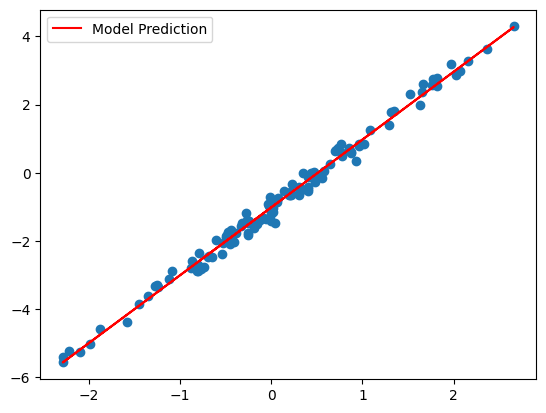

In [11]:
import matplotlib.pyplot as plt

rng = jax.random.key(42)

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
x_rng, noise_rng = jax.random.split(rng)
xs = jax.random.normal(x_rng, (128, 1))
noise = jax.random.normal(noise_rng, (128, 1)) * 0.2
ys = xs * true_w + true_b + noise

# Fit regression
params = init(rng)
for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend();